# Homework:  Sales Data Modeling Deep Dive

The main objectives are to introduce/expand on :
1. Problem setting and data prep
2. Simple feature vs. target analysis 
3. Data Cleaning and Processing
4. Classification modeling 
5. Classification model evaluation using ROC & Precision/Recall
6. Post-modeling feature analysis using feature importance
7. Regression modeling
8. Regression modeling evaluation and analysis
9. Advanced feature analysis using partial dependence
10. A more advanced (and personal) method for performing feature vs. target evaluations

Here are the imports for the rest of the code here. We need __`sklearn`__, __`pandas`__, __`numpy`__, and __`matplotlib`__.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
# conda doesn't have this, you need to : $ pip install pdpbox
from pdpbox import pdp 

/Users/dws/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


The data itself comes from a shared google drive folder.  Link it under the working directory where you are launching jupyter from. **Read in the file WA_Fn-UseC_-Sales-Win-Loss.csv**

In [2]:
dat = pd.read_csv("data/WA_Fn-UseC_-Sales-Win-Loss.csv")

The data is sales information for different opportunities, including contextual information such as region, timeframe, client details, and whether or not the opportunity was a success (Won). **Investigate the data.**

In [3]:
dat.head()

,Opportunity Number,Supplies Subgroup,Supplies Group,Region,Route To Market,Elapsed Days In Sales Stage,Opportunity Result,Sales Stage Change Count,Total Days Identified Through Closing,Total Days Identified Through Qualified,Opportunity Amount USD,Client Size By Revenue,Client Size By Employee Count,Revenue From Client Past Two Years,Competitor Type,Ratio Days Identified To Total Days,Ratio Days Validated To Total Days,Ratio Days Qualified To Total Days,Deal Size Category
0,1641984,Exterior Accessories,Car Accessories,Northwest,Fields Sales,76,Won,13,104,101,0,5,5,0,Unknown,0.69636,0.113985,0.154215,1
1,1658010,Exterior Accessories,Car Accessories,Pacific,Reseller,63,Loss,2,163,163,0,3,5,0,Unknown,0.00000,1.000000,0.000000,1
2,1674737,Motorcycle Parts,Performance & Non-auto,Pacific,Reseller,24,Won,7,82,82,7750,1,1,0,Unknown,1.00000,0.000000,0.000000,1
3,1675224,Shelters & RV,Performance & Non-auto,NaN,Reseller,16,Loss,5,124,124,0,1,1,0,Known,1.00000,0.000000,0.000000,1
4,1689785,Exterior Accessories,Car Accessories,Pacific,Reseller,69,Loss,11,91,13,69756,1,1,0,Unknown,0.00000,0.141125,0.000000,4


# 1) Problem Setting 

Problem setting in Machine Learning involves asking questions about the problem requiring modeling.  Does the model objective make sense given the data?  We're handing you the data and modeling context here.  

We would like to model: 
1. The likelihood of winning a given deal 
1. The total expected value of a won deal.


# 2) Feature/Target Plots

All supervised learning models require an objective or "target" field.  This is the value that the model will try and predict given a set of feature data.  Best practice for modeling involves investigating how a given feature field and the target field relate.  This process helps understand the potential utility of a given feature for predicting the target, as well as identify potential problems in the feature or target.

Plot each feature/target interaction (i.e. every field vs. Opportunity Result and every field vs. Opportunity Amount USD)

1. Which plot did you use for the comparison?  (How do you handle categorical vs. numeric and categorical vs. numerical?)
2. What features look useful for prediction?
3. Are there features that could be modified?  (numeric to categorical, etc.)
4. What features are leakage?
5. What features are noise?
6. Imagine this dataset was given to us by engineering.  What other follow up questions might we ask?



## 2) INSTRUCTOR ANSWERS:
1. Which plot did you use for the comparison?  (How do you handle categorical vs. numeric and categorical vs. numerical?)
    1. Simple scatter plot code given below
2. What features look useful for prediction?
    1. Predicting Opportunity Result:
        1. Revenue From Client Past Two Years
        2. Route To Market_Reseller	
    2. Predicting Opportunity Amount:
        1. Revenue From Client Past Two Years
        2. Deal Size Category
    
3. Are there features that could be modified?  (numeric to categorical, etc.)
    1. Deal Size Category seems ordinal, but probably should be cast to categorical for simpler (linear) models.
4. What features are leakage?
    1. Opportunity Amount is a leakage field for predicting Opportunity Result
5. What features are noise?
    1. Opportunity Number looks like an ID number and should be removed from the features
6. Imagine this dataset was given to us by engineering.  What other follow up questions might we ask?
    1. Opportunity Number looks like it has some gaps.  Are we missing data?

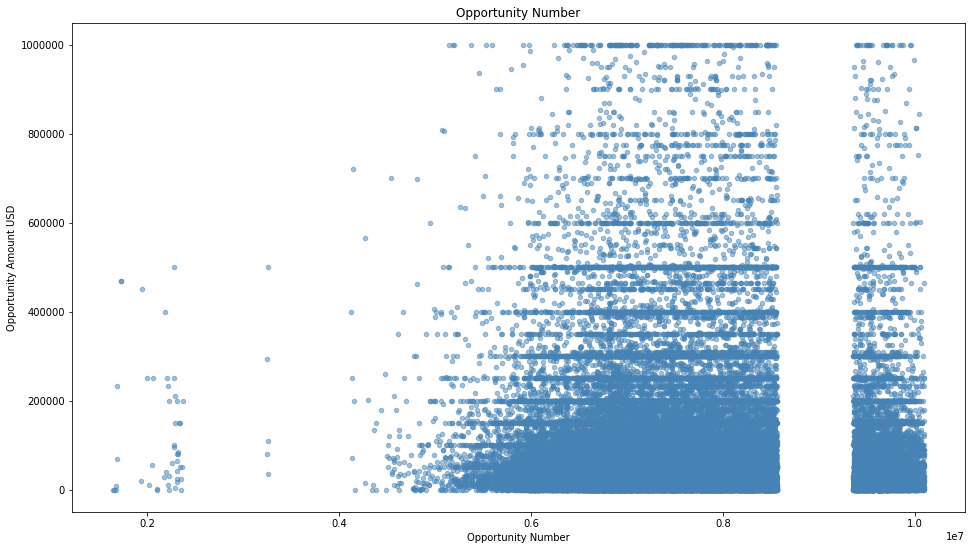

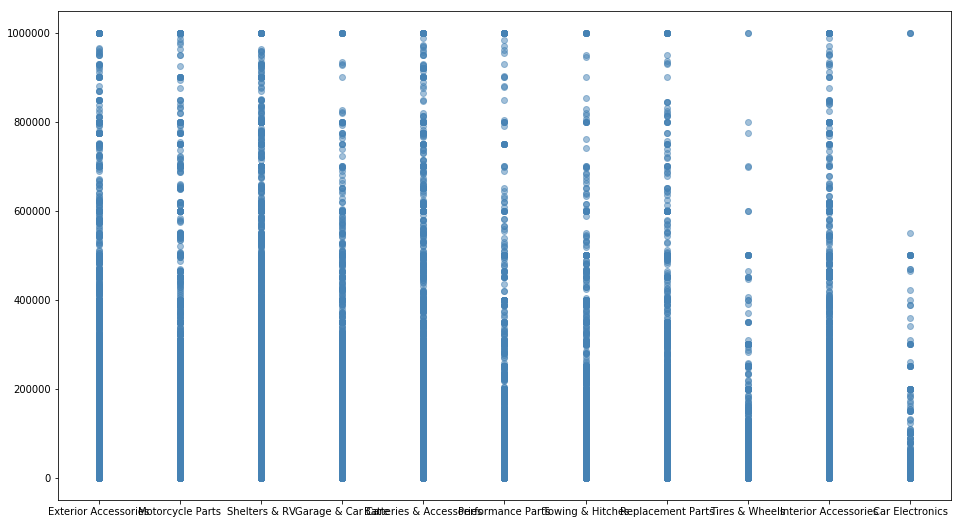

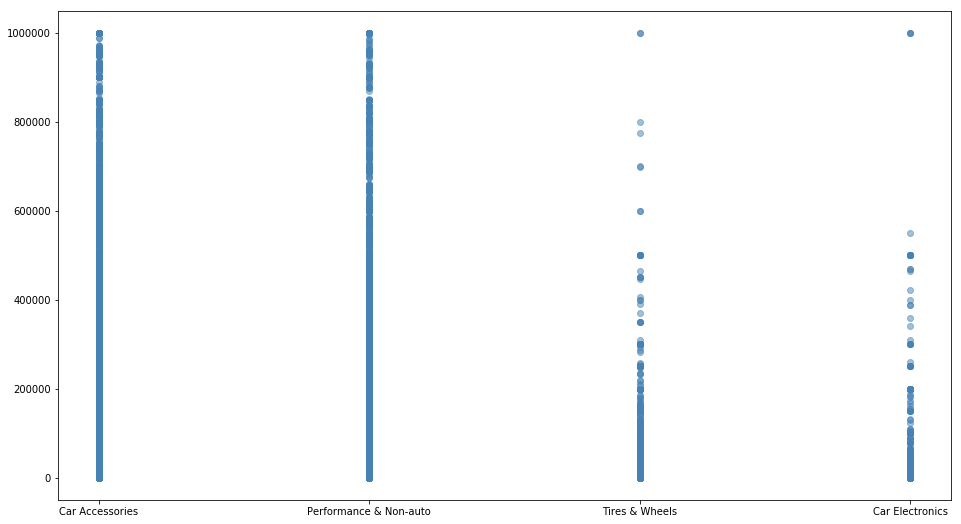

TypeError: nan is not a string

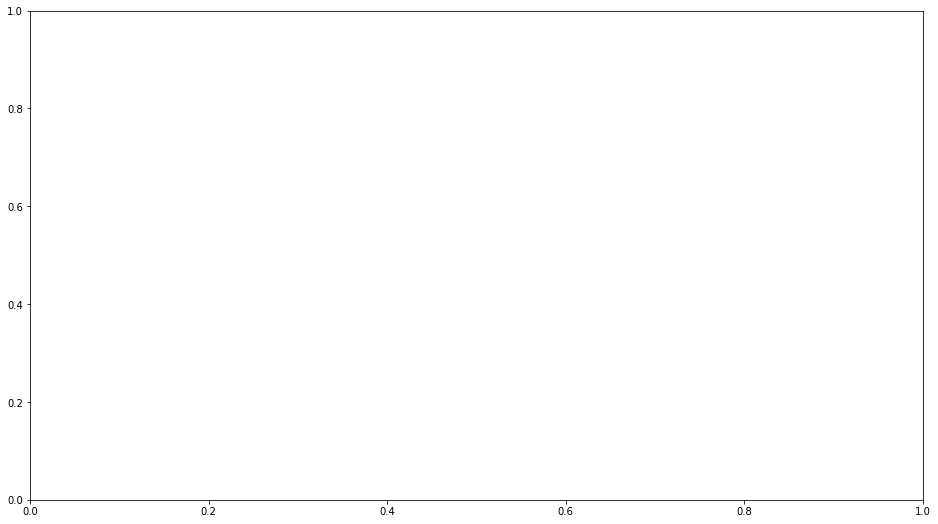

In [4]:
# INSTRUCTOR CODE
# This code simply loops through all of the values and creates simple scatter plots for the Opportunity Amount USD target.
# The same approach can be used for Opportunity Result.
# Other plotting styles are appropriate, e.g. box plots.  Some of them are not as simple to do in python.

target = 'Opportunity Amount USD'
from pandas.api.types import is_numeric_dtype

for c in dat.columns:
    if c == target :
        continue
    elif (is_numeric_dtype(dat[c])):
        dat.plot.scatter(c,target,alpha = 0.5, figsize=(16,9), title=c, color="steelblue")
    else:
        if (len(dat[c].value_counts()) > 12):
            print("Too many categories for", c)
            continue
        plt.figure(figsize=(16,9))
        plt.plot(c,target,"bo", data=dat, alpha = 0.5, color="steelblue")
 
    plt.show();


# 3) Data Processing/Cleaning
The data above contains categorical data.  Unfortunately, scikit learn does not support categorical data for most of its model types.  As a first step, we will turn categorical lable fields into a series of per-label boolean fields (this process is called binarization).  The cell below will print out the list of original field names as well as the final binarized versions.

We also need to drop fields from training because they are not valid measurements (Opportunity Number, which is an ID), they are *[leakage](https://www.kaggle.com/wiki/Leakage)* fields (Opportunity Amount USD, which is only populated if the Opp is won), or are the objective field itself (Opportunity Result).

In [5]:
# Categorize any numeric field
def categorize(dat, field):
    dat[field] = dat[field].astype("str")
    
# Deal Size Category becomes a plain string field
categorize(dat, "Deal Size Category")

# Convert Opportunity Result to a simple boolean vector
output = dat['Opportunity Result'] == "Won"

# Drop all target/leakage fields for Opportunity Result
dat_filtered = dat.drop(["Opportunity Result","Opportunity Number","Opportunity Amount USD"],axis=1)
dat_filtered = pd.get_dummies(dat_filtered)

print('***ORIGINAL***\n', dat.columns)
print('\n')
print('***BINARIZED***\n', dat_filtered.columns)

***ORIGINAL***
 Index(['Opportunity Number', 'Supplies Subgroup', 'Supplies Group', 'Region',
       'Route To Market', 'Elapsed Days In Sales Stage', 'Opportunity Result',
       'Sales Stage Change Count', 'Total Days Identified Through Closing',
       'Total Days Identified Through Qualified', 'Opportunity Amount USD',
       'Client Size By Revenue', 'Client Size By Employee Count',
       'Revenue From Client Past Two Years', 'Competitor Type',
       'Ratio Days Identified To Total Days',
       'Ratio Days Validated To Total Days',
       'Ratio Days Qualified To Total Days', 'Deal Size Category'],
      dtype='object')


***BINARIZED***
 Index(['Elapsed Days In Sales Stage', 'Sales Stage Change Count',
       'Total Days Identified Through Closing',
       'Total Days Identified Through Qualified', 'Client Size By Revenue',
       'Client Size By Employee Count', 'Revenue From Client Past Two Years',
       'Ratio Days Identified To Total Days',
       'Ratio Days Validated To

For most modeling tasks, we need to split the data into a train and test set.  We train the model on one set of data, and then evaluate it on another.  Models are always at risk of *[overfitting](https://en.wikipedia.org/wiki/Overfitting)* the data they are trained on.  Evaluating a model on new data gives a better understanding of its potential performance in a real world scenario.

The function below splits the filtered data and objective field into train/test counterparts.  The result below shows the shape of the two datasets generated:  ~68K records for training, and ~10K records for evaluation.  

There's no hard and fast rule for what ratio to use.  Generally an evaluation set that contains 10%-20% of the original data is a good place to start. You'll also need a minimum number of records for evaluation, which differs depdending on the dataset characteristics.  We usually want a few hundred records for simple linear modeling tasks, up through millions for more complex tasks involving many features (especially in NLP domains).

For a more formal evaluation, consider using [cross-fold validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)

In [6]:
train_split, test_split, train_output, test_output = train_test_split(dat_filtered, output, test_size=10000)
print(train_split.shape)
print(test_split.shape)

(68025, 47)
(10000, 47)


# 4) Classification Modeling
Once the data is prepared, training is a snap.  We create the model, and pass in the train/objective data as arguments. **Create a LogisticRegression and train it on the data.**

In [7]:
logreg = LogisticRegression()
logclf = logreg.fit(train_split, train_output)

# 5) Classification Evaluation using ROC & Precision/Recall

ROC and PR curves are powerful binary classifier evaluation techniques.  The curves represent different combinations of metrics under different sensitivity specifications.

The difference between them is apparent by looking at their respective formula components:

ROC, comprised of True Positive Rate (TPR) and False Positive Rate (FPR) : 

\begin{align}
\mathit{TPR} = \frac{\mathit{TP}}{\mathit{TP}+\mathit{FN}}
\end{align}

\begin{align}
\mathit{FPR} = \frac{\mathit{FP}}{\mathit{TN} + \mathit{FP}}
\end{align}

Precision Recall, comprised of Precision (AKA TPR) and Recall

\begin{align}
\mathit{Precision} = \frac{\mathit{TP}}{\mathit{TP}+\mathit{FP}}
\end{align}

\begin{align}
\mathit{Recall} = \frac{\mathit{TP}}{\mathit{TP} + \mathit{FN}}
\end{align}

We'll create small helper functions for evaluation.  One function creates an *[ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)* curve, which helps understand the model performance across a range of sensitivity settings.  The area of the curve drawn by ROC ([AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve)), is a good overall performance metric for a binary classifier.  The other function creates a [precision recall curve](https://en.wikipedia.org/wiki/Precision_and_recall).  The average precision (weighted by the recall count at each point) is given as the *average precision score*.

In [8]:
def roc(model, data, actual):
    probas = model.predict_proba(data)[:,1]
    fpr, tpr, thr = roc_curve(actual, probas)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label="AUC = %0.2f" % roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.title('Receiver Operating Characteristic')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
    
def pr(model, data, actual):
    probas = model.predict_proba(data)[:,1]
    precision, recall, _ = precision_recall_curve(actual, probas)
    pr_ap = average_precision_score(actual, probas)
    plt.plot(recall, precision, 'b', label="AVP = %0.2f" % pr_ap)
    plt.title('Precision Recall')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.legend(loc='lower right')
    plt.show()


## 5a) ROC/PR for Logistic Regression

**Evaluate the LogisticRegression results using both of these plot methods.**

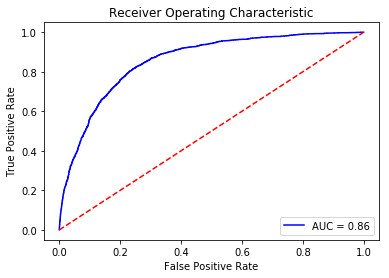

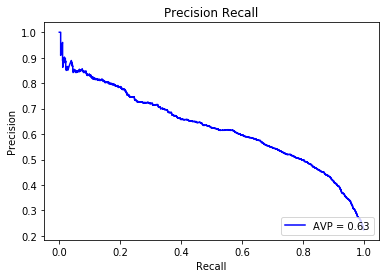

In [9]:
roc(logclf, test_split, test_output)
pr(logclf, test_split, test_output)

## 5b) ROC/PR for Random Forest
**Create and evaluate a random forest model using the plot methods given above.**

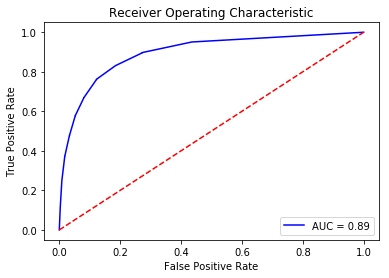

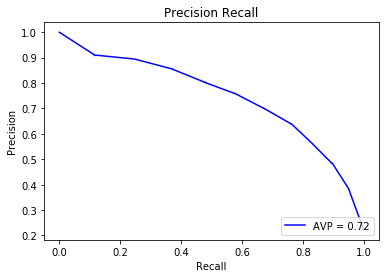

In [10]:
# INSTRUCTOR CODE
rf = RandomForestClassifier()
rfclf = rf.fit(train_split,train_output)

roc(rfclf, test_split, test_output)
pr(rfclf, test_split, test_output)

## 5c) Questions on Model Performance for Binary Classification

Now that we have two models and two evaluations using two techniques, here are some questions:

1. Which model (rf/lr) performed the best?
2. Which model would you choose to implement in a production system?
3. What would a "perfect" ROC curve look like?
4. What would a "perfect" PR curve look like?
5. Why are perfect curves not ideal in model evaluations?



## 5c) INSTRUCTOR ANSWERS

1. Which model (rf/lr) performed the best?
    1. The random forest model had a higher AUC and AVP
2. Which model would you choose to implement in a production system?
    1. This is an open ended discussion... the Linear model does nearly as well as the RF model, and is much simpler.  However, small sales model improvements can easily "pay off" the cost overhead of a complex random forest model.
3. What would a "perfect" ROC curve look like?
    1. A right angle from the origin to 1.0 true positive rate, extending horizontally to 1.0 false positive rate. 
4. What would a "perfect" PR curve look like?
    1. A line extending horizontally from 1.0 precision to 1.0 recall
5. Why are perfect curves not ideal in model evaluations?
    1. Models with perfect curves in all likelihood are trained on leakage data, or have severe overfitting problems.



# 6) Feature Analysis Techniques using Feature Importance

After a model is trained, we can examine it to determine which features it relied on the most during training.

Logistic regression have coefficients based on the features they are trained on.  Inspecting these coefficients reveal which features the model believes are important for prediction, and whether those features have a positive or negative impact on the predicted score.  We can look at a sorted list for the best-to-worst indicators of a successful opportunity. **Print out a sorted list of the coefficients in order of their importance.**

In [11]:
coef = pd.DataFrame({
    "coef" : logclf.coef_[0].tolist()
}, index=train_split.columns)

coef.sort_values('coef', ascending=False)

,coef
Deal Size Category_1,0.774030
Revenue From Client Past Two Years,0.652462
Route To Market_Reseller,0.523130
Sales Stage Change Count,0.406271
Ratio Days Qualified To Total Days,0.295838
Deal Size Category_2,0.191233
Supplies Subgroup_Garage & Car Care,0.141241
Supplies Subgroup_Exterior Accessories,0.136053
Supplies Group_Car Electronics,0.077748
Supplies Subgroup_Car Electronics,0.077748


Random forests do not use coefficients.  Instead, they have a series of split criteria scattered across a multitude of decision trees.  We calculate feature importance by measuring the *[information gain](https://en.wikipedia.org/wiki/Information_gain_in_decision_trees)* of each split point for its given feature.  If a split point uses a feature to effectively separate a large amount of data, the importance score for that split is added to the feature.  All importance scores are then tallied.  Scikit provides this information as part of the fitted model object.

Note that we *cannot* deduce whether the feature has an overall positive or negative effect on the score based on its importance.  Inside a  non-linear model like a random forest, a given feature value could have positive *and* negative effects at multiple parts of a tree, and in multiple trees in the forest. **Print out a sorted list of the importances for the Random forest model you created above.**

In [12]:
feature_importances = rfclf.feature_importances_

importances = pd.DataFrame({
    "importance" : feature_importances
}, index = train_split.columns)

importances.sort_values("importance", ascending=False)

,importance
Elapsed Days In Sales Stage,0.136104
Total Days Identified Through Qualified,0.115389
Revenue From Client Past Two Years,0.104407
Total Days Identified Through Closing,0.096487
Ratio Days Qualified To Total Days,0.070937
Sales Stage Change Count,0.066408
Ratio Days Validated To Total Days,0.053399
Ratio Days Identified To Total Days,0.039746
Deal Size Category_1,0.021391
Route To Market_Reseller,0.019122


# 7) Regression Modeling

If an opportunity is "won", the data provides additional information on the amount of money the opportunity is worth.  We can capture this data and model it separately as a linear regression.  We just need to filter for "won" opportunities.

In [13]:
won = dat[dat["Opportunity Result"] == "Won"].drop(["Opportunity Result", "Opportunity Number"], axis=1)
won_output = won["Opportunity Amount USD"]
won = won.drop(["Opportunity Amount USD"], axis=1)
won = pd.get_dummies(won)
won_train, won_test, won_train_output, won_test_output = train_test_split(won, won_output, test_size=10000)

In [14]:
regr = LinearRegression()
linreg = regr.fit(won_train, won_train_output)

## 8) Regression modeling evaluation and analysis

For regression analysis, the model predicts a value that should be "close" to the actual value.  The difference between these values is an individual error measurement.  The individual error measurements can be averaged over a test dataset to form an understanding of the error range for a given model.  It's usually a good idea to compare a mean absolute/squared error to the mean of the value within the dataset.

In [15]:
y_pred = linreg.predict(won_test)
y_actual = won_test_output
print("mae : $" , mean_absolute_error(y_actual, y_pred))
# print("mse : $" , mean_squared_error(y_actual, y_pred))
print("mean: $", np.mean(y_actual ))

mae : $ 15276.182576461995
mean: $ 72038.6901


We can dig deeper into the results of the model by better understanding the distribution of actual values.  To do that, we can create a small histogram generation function.

In [16]:
def gen_histogram(dist, x_label, y_label, main, log_scale=False):
    n, bins, patches = plt.hist(dist, 100, normed=1, facecolor='green', alpha=0.75)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(main)
    plt.grid(True)
    if log_scale:
        plt.yscale('log', nonposy='clip')
    plt.show()

We can look at the histogram of opportunity amounts.  This looks like a fairly standard distribution with an exponential fall-off.  We can look at this information in original or log scaling

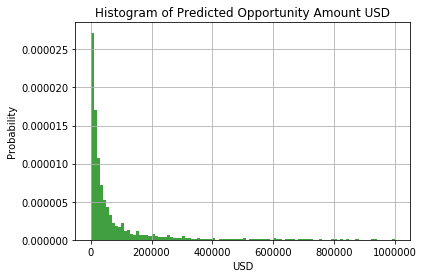

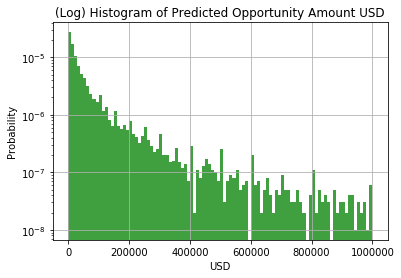

In [17]:
gen_histogram(y_actual, 'USD','Probability','Histogram of Predicted Opportunity Amount USD')
gen_histogram(y_actual, 'USD','Probability','(Log) Histogram of Predicted Opportunity Amount USD', True)

We can look at the distribution of *residuals* from the model.  The residuals are the predicted amounts subtracted from the original opportunity amounts.

The histogram shows that most of the errors are centered around 0, which is a good sign.  The distribution looks a bit bimodal... or rather trimodal.  Finding lumps of errors and/or misclassifications like this typically can highlight records that the model gets consistently wrong.  

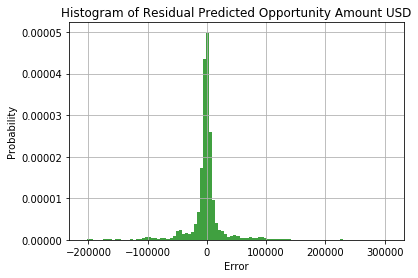

In [18]:
residual = y_actual - y_pred
gen_histogram(residual, 'Error','Probability','Histogram of Residual Predicted Opportunity Amount USD')

Linear regression coefficients can be interpreted more or less the same as logistic regression coefficients.

In [19]:
coef = pd.DataFrame({"coef" : linreg.coef_.tolist()},index=won_train.columns)
coef.sort_values('coef', ascending=False)

,coef
Deal Size Category_7,509217.568433
Deal Size Category_6,164377.548443
Supplies Subgroup_Interior Accessories,2980.760543
Competitor Type_Known,2729.645512
Region_Pacific,2601.676855
Supplies Subgroup_Shelters & RV,2352.962589
Route To Market_Reseller,1268.374987
Supplies Subgroup_Replacement Parts,1137.145833
Route To Market_Telesales,1064.435486
Route To Market_Fields Sales,924.823096


## 8a) Regression Modeling using Random Forests
**Create a random forest model and evaluate it using the same approach as the linear regressor. Train it, generate predictions for your test data, calculate the MAE and mean for the predictions versus the test data.**

1. Which model performs the best?
2. Compare the residuals from both models, are there any differences?
3. Which model would you chose for production?

## 8a) INSTRUCTOR ANSWERS
Create a random forest model and evaluate it using the same approach as the linear regressor.

1. Which model performs the best?
    1. Linear regression
2. Compare the residuals from both models, are there any differences?
    1. Random forest residuals are much smoother, but the range of errors is greater.
3. Which model would you chose for production?
    1. Linear modeling is an easy choice, it performs better and is simpler

In [20]:
# INSTRUCTOR CODE
regr = RandomForestRegressor(n_estimators=20,max_features=20)
rfreg = regr.fit(won_train, won_train_output)


y_pred = rfreg.predict(won_test)
y_actual = won_test_output
print("mae : $" , mean_absolute_error(y_actual, y_pred))
# print("mse : $" , mean_squared_error(y_actual, y_pred))
print("mean: $", np.mean(y_actual ))

mae : $ 15414.005720589736
mean: $ 72038.6901


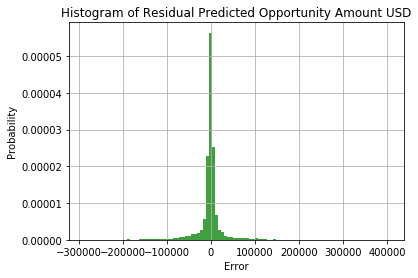

In [21]:
# INSTRUCTOR CODE
residual = y_actual - y_pred
gen_histogram(residual, 'Error','Probability','Histogram of Residual Predicted Opportunity Amount USD')

# 9) BONUS: Advanced Feature Analysis With Partial Dependence 

It's still possible to understand the effects of a given feature range using techniques like *[partial dependence plots](https://towardsdatascience.com/introducing-pdpbox-2aa820afd312)*.  These techniques evaluate the predicted value for the given data, while sweeping a given feature through its entire range.  It's possible to understand if a given feature produces a linear response in the predicted value, or if it suggests a more complex (or non-linear) function.  

In this case, we'll look at "Total Days Identified Through Closing".  This feature gives the number of days the deal has been active.  It's clear that likelihood for a deal to close increases through its age, but only to a point.  After that point, the likelihood of it closing falls off dramatically.  A more complex distribution like this is not going to be modeled well by a simpler model.  However, the random forest is able to capture this behavior through training.

As an aside, scikit learn does not provide a default partial dependence plot function for random forests.  A seperate library is utiltized here.  The ICEplot title refers to the paper and technique for *[Individual Conditional Expectation](https://arxiv.org/abs/1309.6392)*

By examining the confidence or output of the model over the range of the feature, we can better understand the impact of the feature on the target field over the range of the feature.  In some cases, features have a *non-linear* effect on the target.  That is, a feature may have a positive effect on the target that changes suddenly over certain ranges.  Partial dependence plots expose this behavior as a simple line chart.

In [22]:
for c in train_split.columns:
    pdp_elapsed = pdp.pdp_isolate(rfclf, train_split, c)
    pdp.pdp_plot(pdp_elapsed, c, frac_to_plot=5000)
    plt.show()

TypeError: pdp_isolate() missing 1 required positional argument: 'feature'

## 10) Advanced Feature Analysis Mosaic plots : Feature vs. Target

Here's a different feature analysis technique that is an extrapolation of [mosaic plots](https://en.wikipedia.org/wiki/Mosaic_plot).

This plot shows the relative proportional distribution of datapoints within each feature bin compared to the proportional distribution within the target bin. 

Bins are derived directly from category fields. They can also be derived from a histogram decomposition of a numeric field.

The benefits of this approach include:

1. Can be applied to any numeric/categorical feature combination
2. Does not suffer from occlusion/outlier skewing
3. Gives a good overview of relative importance and proportion of data within difference categories/ranges.

In [23]:
from statsmodels.graphics.mosaicplot import mosaic
cat_colormap = plt.cm.get_cmap("Pastel2", 8) #nipy_spectral, Set1,Paired 
lin_colormap = plt.cm.get_cmap("RdYlGn", 8) #nipy_spectral, Set1,Paired 

def topn(dat, col, top=7):
    top_labels = dat[col].value_counts().sort_values(ascending=False)[0:top].index
    topmod = dat[col].map(lambda label: "NA_TOPN" if label not in top_labels else label)
    return topmod

def topbin(dat,col):
    if dat[col].dtype == "object":
        return topn(dat, col).reset_index(drop=True)
    else :
        counts, bins = np.histogram(dat[col], bins=8) 
        buckets = bins[np.digitize(dat[col], bins)-1].round(2).astype("str")
        col_label = col + " Bins"
        return pd.Series(data = buckets, name=col_label).reset_index(drop=True)
    
def umosaic(dat, feature, target, invert_colors=False):
    fig, ax = plt.subplots(figsize=(16, 9))
    datsrt = dat.sort_values([target,feature], ascending=[True,True])
    feat = topbin(datsrt, feature)
    targ = topbin(datsrt, target)
    datmos = pd.DataFrame({feature : feat, target : targ})
    
    def lab(v):
        return v[1]
    
    def props(v):
        value = v[1]
        if (dat[target].dtype=="object"):
            ordered = targ.value_counts().sort_values(ascending=False).index.tolist()
            colormap = cat_colormap
        else:
            ordered = targ.value_counts().index.astype("float").sort_values(ascending=False).tolist()
            ordered = [str(o) for o in ordered]
            colormap = lin_colormap
            
        if (invert_colors):
            color_dict = {v : len(ordered) - i -1  for i,v in enumerate(ordered)}
        else:
            color_dict = {v : i  for i,v in enumerate(ordered)}
        def adj_trans(c):
            return (c[0],c[1],c[2],.5)
        
        return {"color" : adj_trans(colormap(color_dict[value]))}
            
    mosaic(datmos, [feature, target], properties = props, labelizer=lab, title="%s vs. %s" % (feature, target),ax=ax)

In [ ]:
%matplotlib inline
import matplotlib.patches as mpatches

target = 'Opportunity Result'
mdat = dat

# target = 'Opportunity Amount USD'
# mdat = dat[dat["Opportunity Result"] == "Won"]
# mdat[target] = np.log10(mdat[target] + 1)

for c in mdat.columns:
    if c == target:
        continue
    print(c)
    umosaic(mdat, c, target, True)
    plt.show()

Non-normalized version


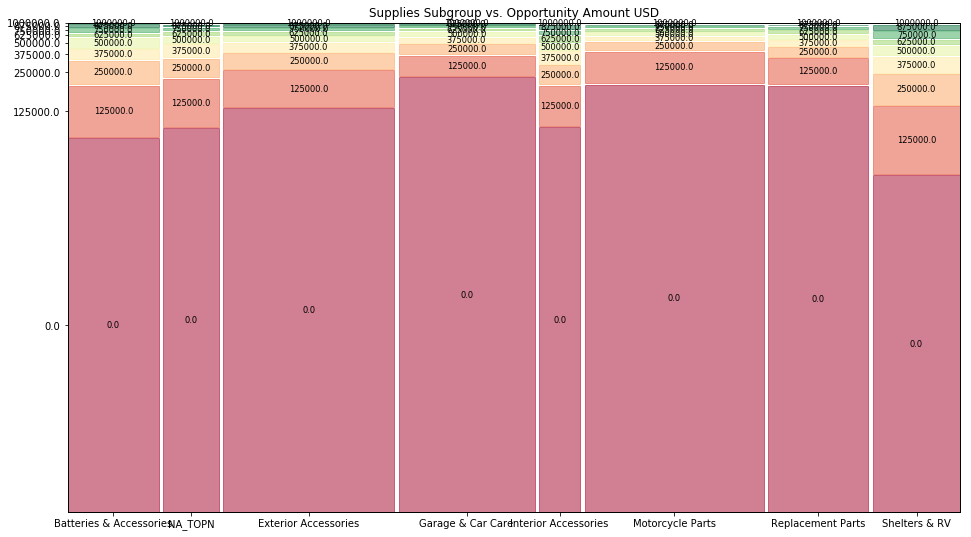

Normalized versions
Opportunity Number


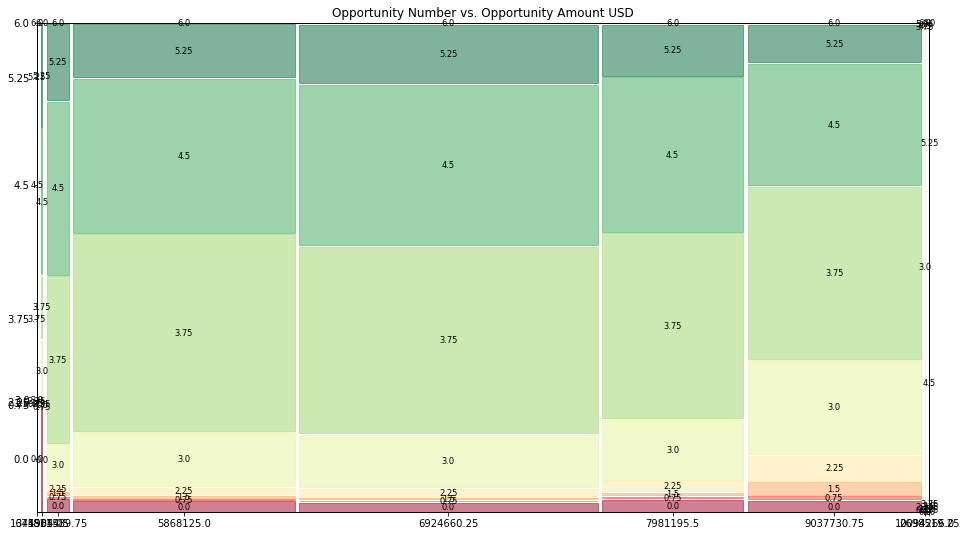

Supplies Subgroup


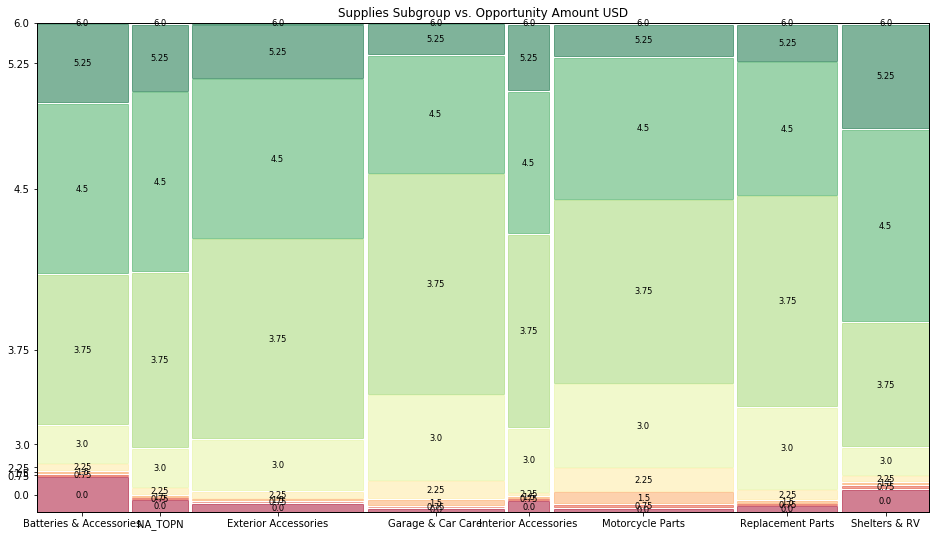

Supplies Group


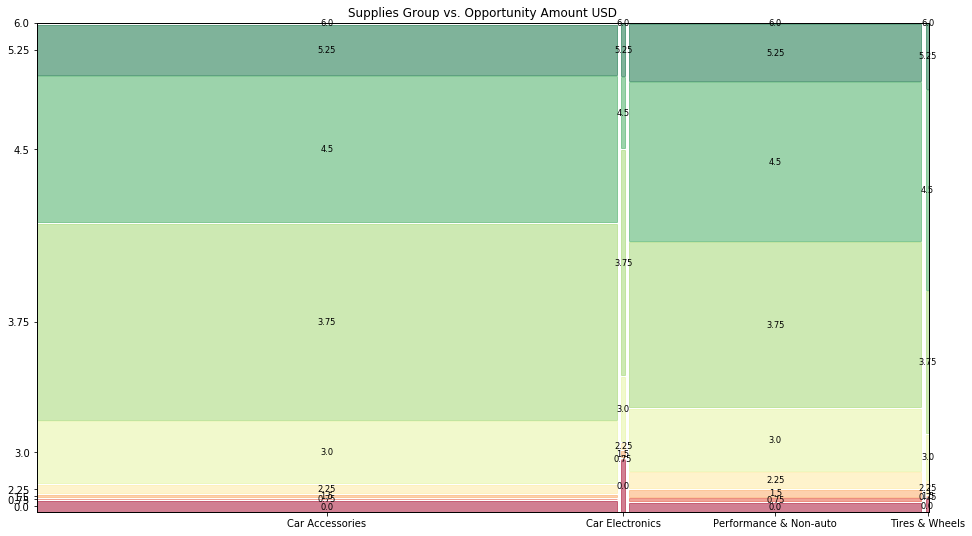

Region


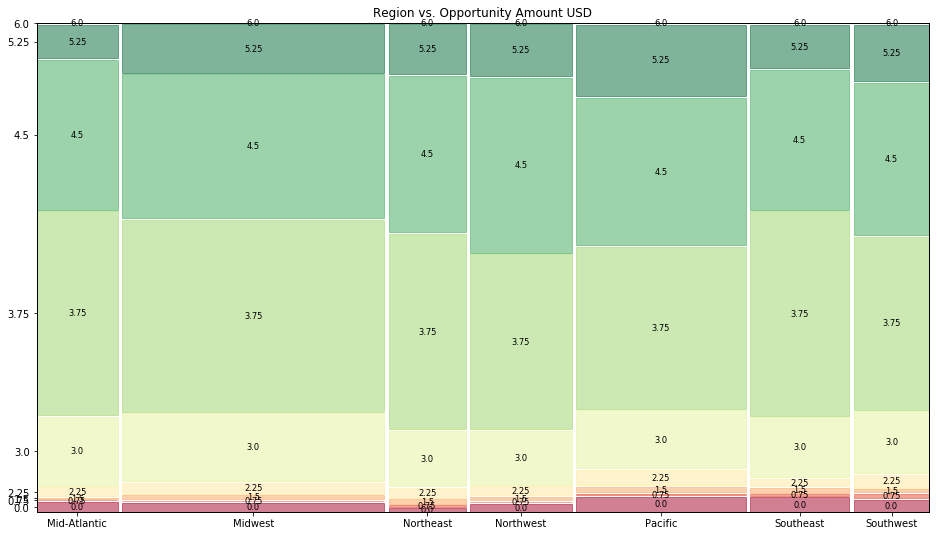

Route To Market


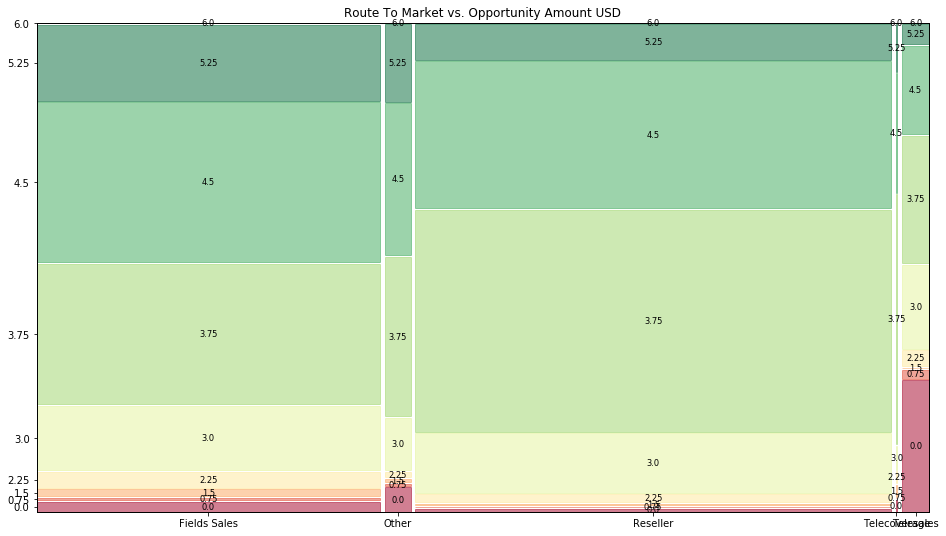

Elapsed Days In Sales Stage


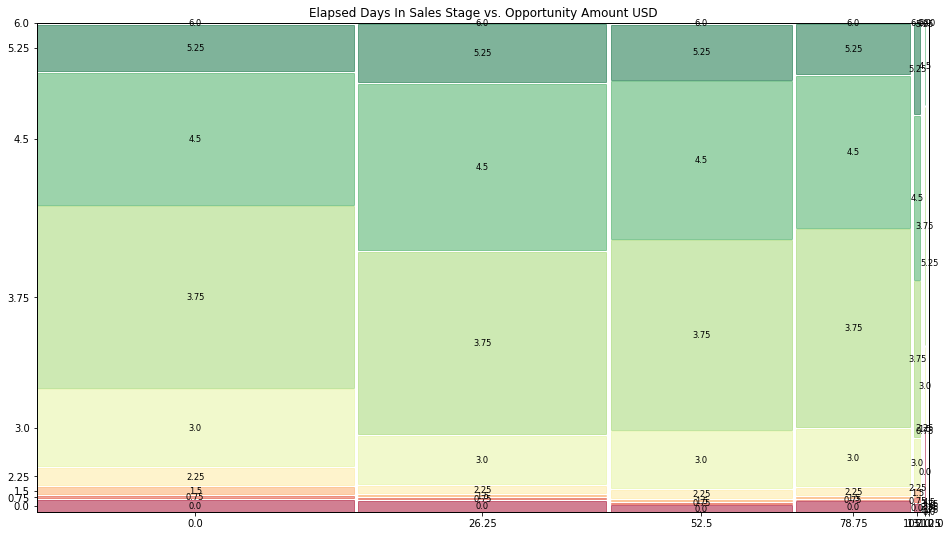

Opportunity Result


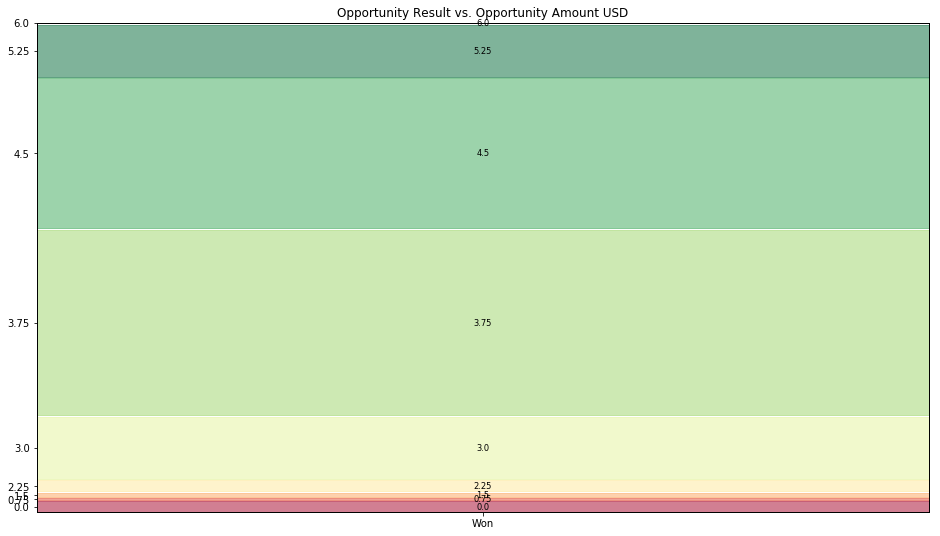

Sales Stage Change Count


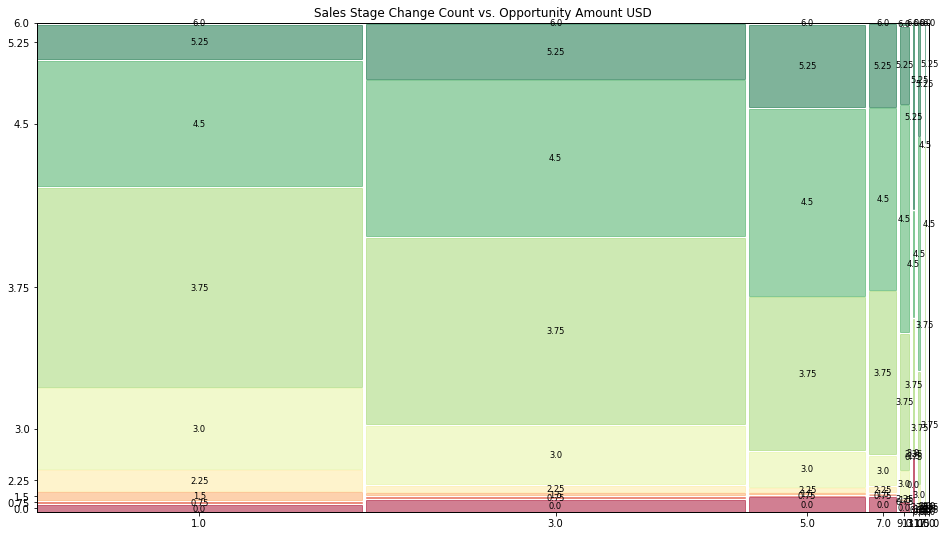

Total Days Identified Through Closing


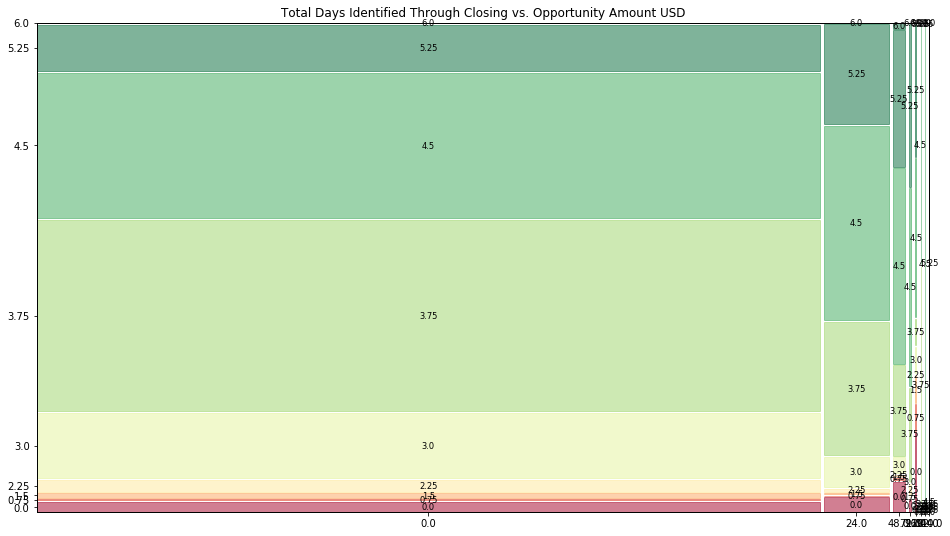

Total Days Identified Through Qualified


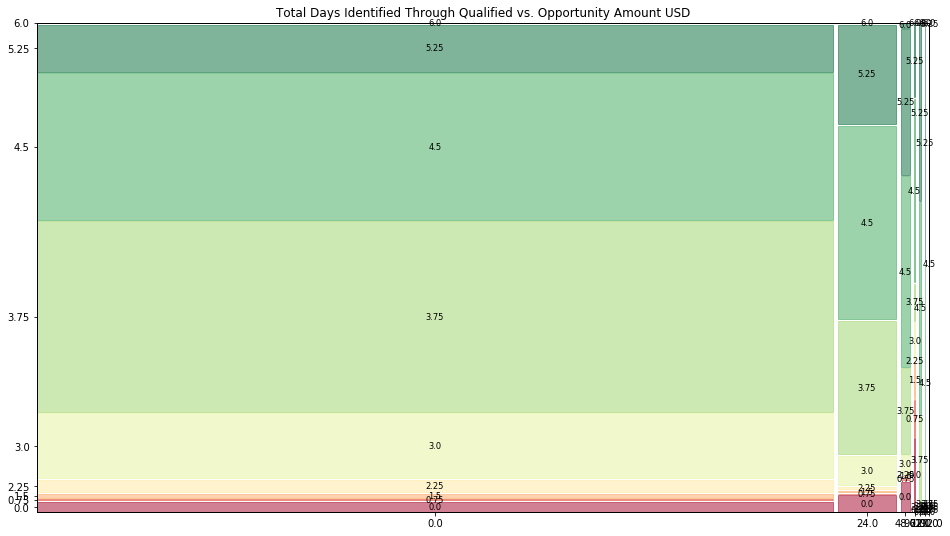

Client Size By Revenue


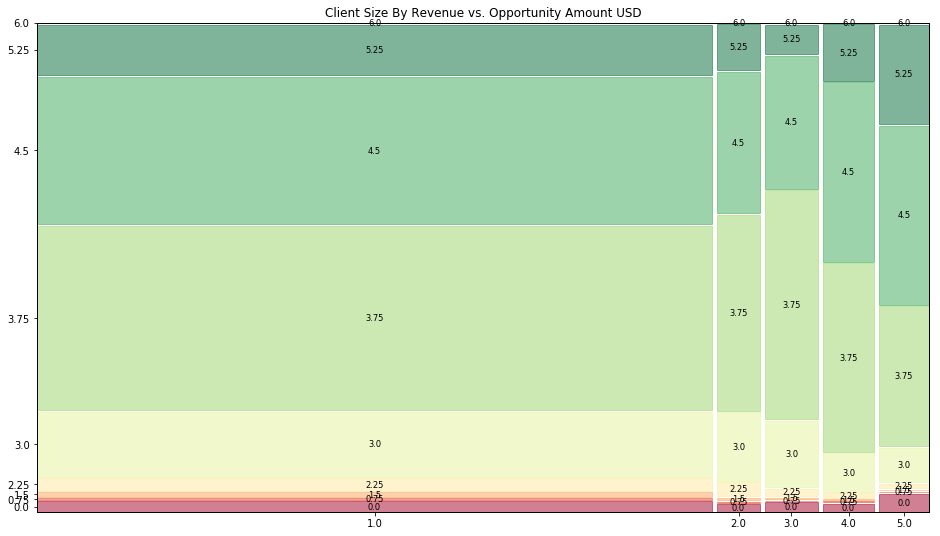

Client Size By Employee Count


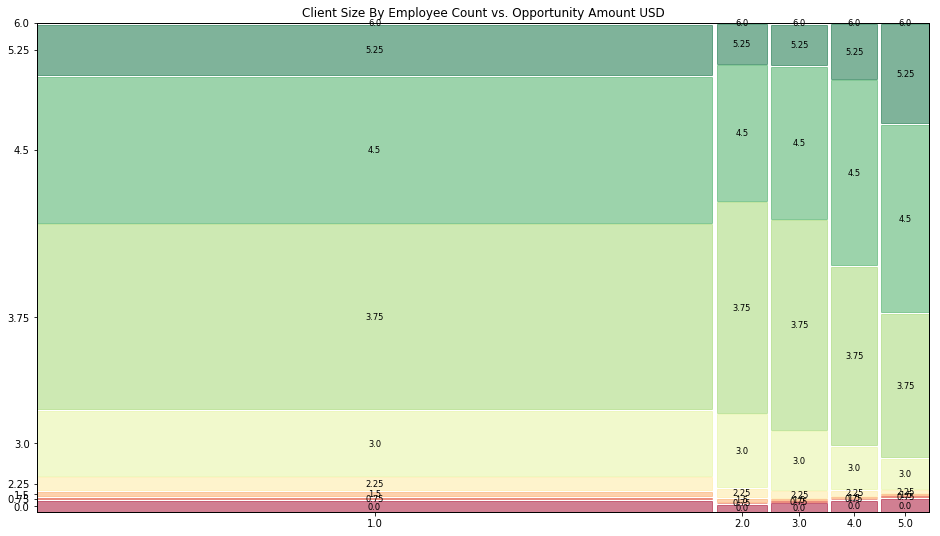

Revenue From Client Past Two Years


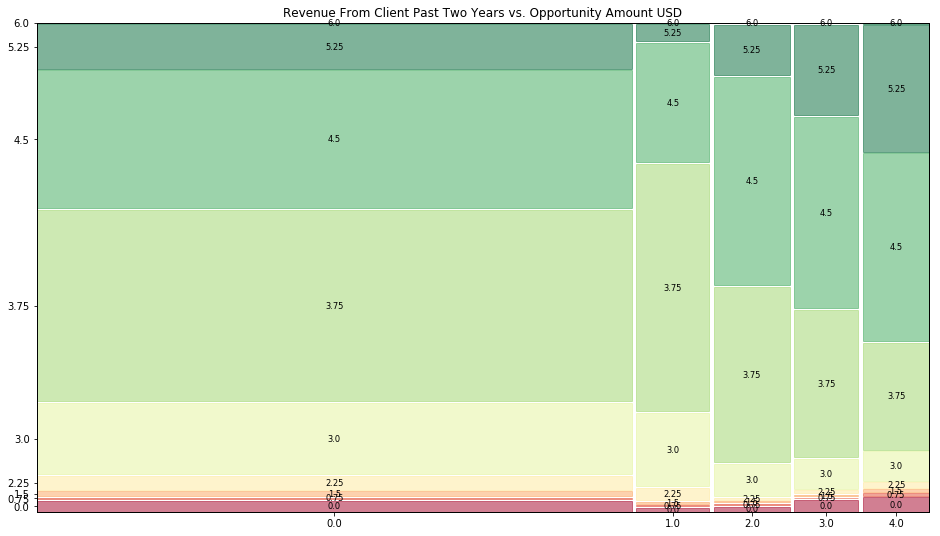

Competitor Type


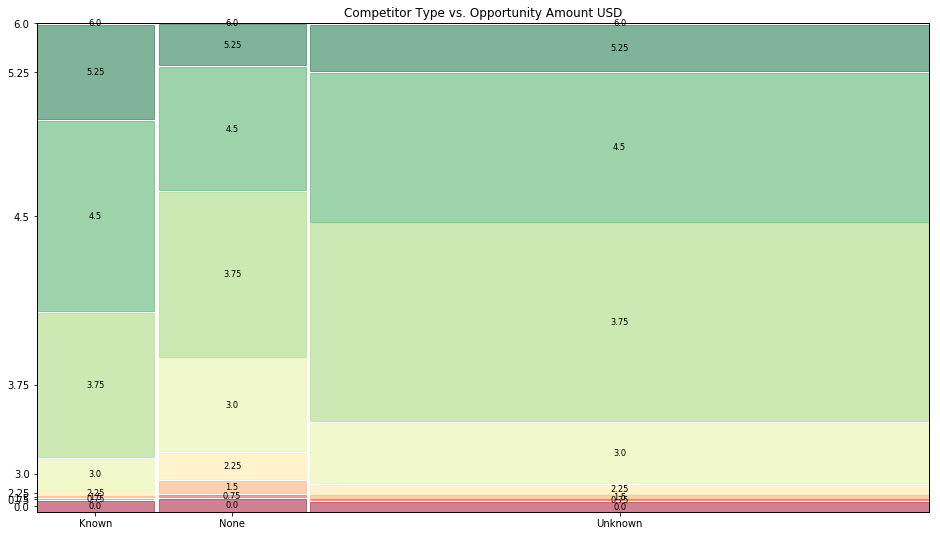

Ratio Days Identified To Total Days


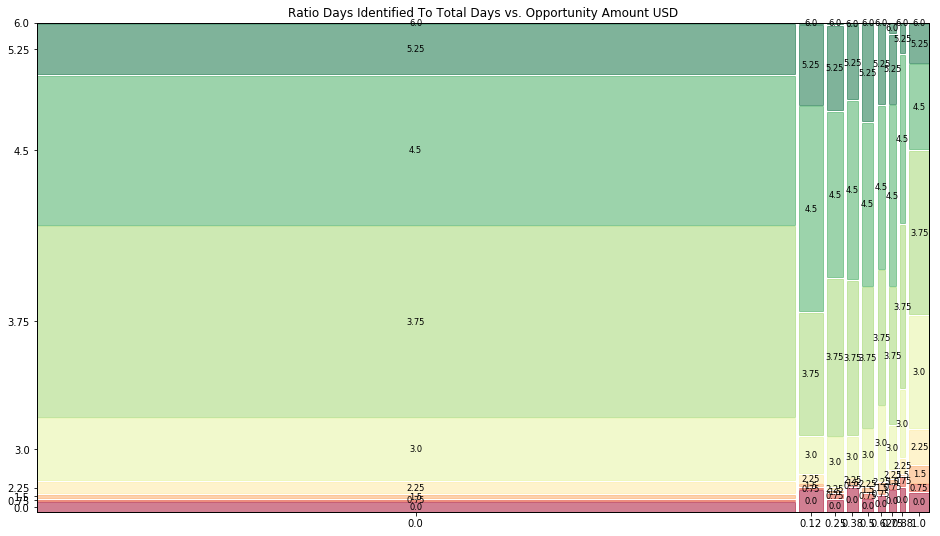

Ratio Days Validated To Total Days


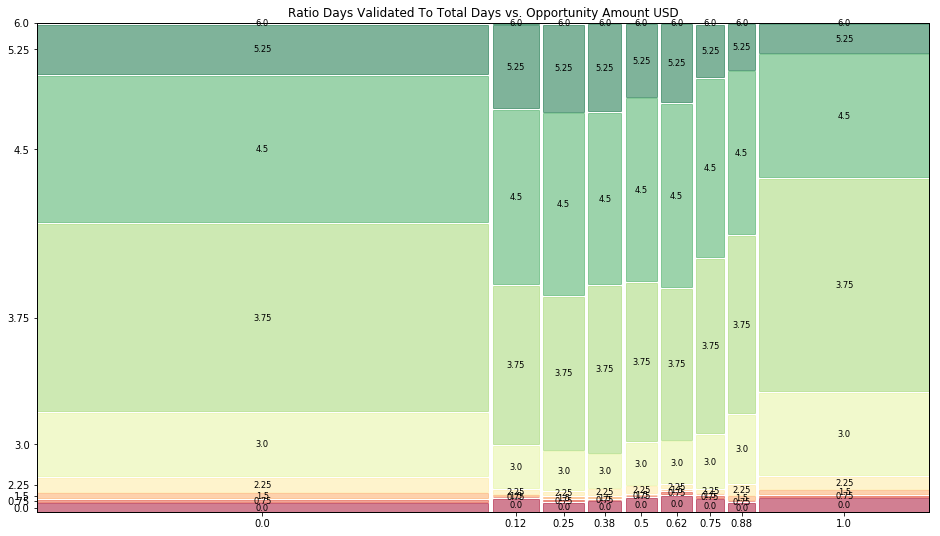

Ratio Days Qualified To Total Days


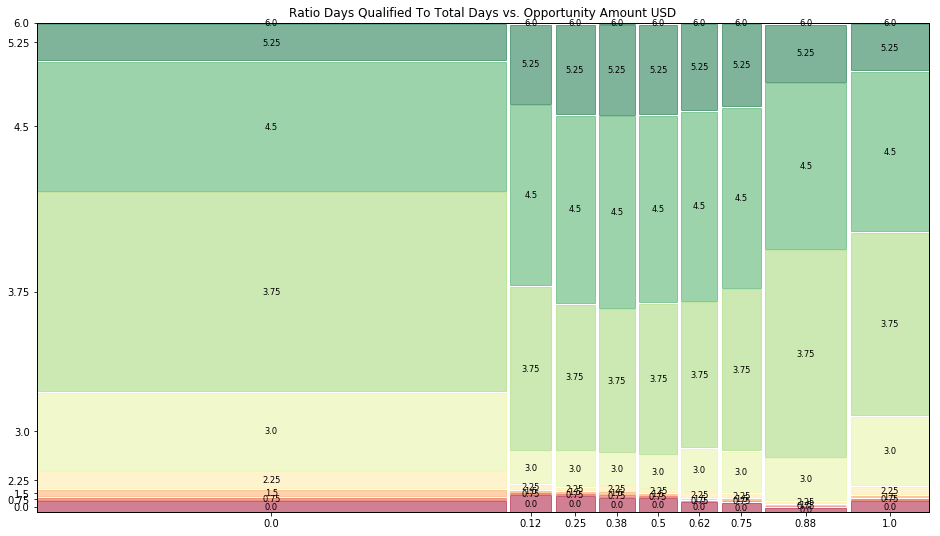

Deal Size Category


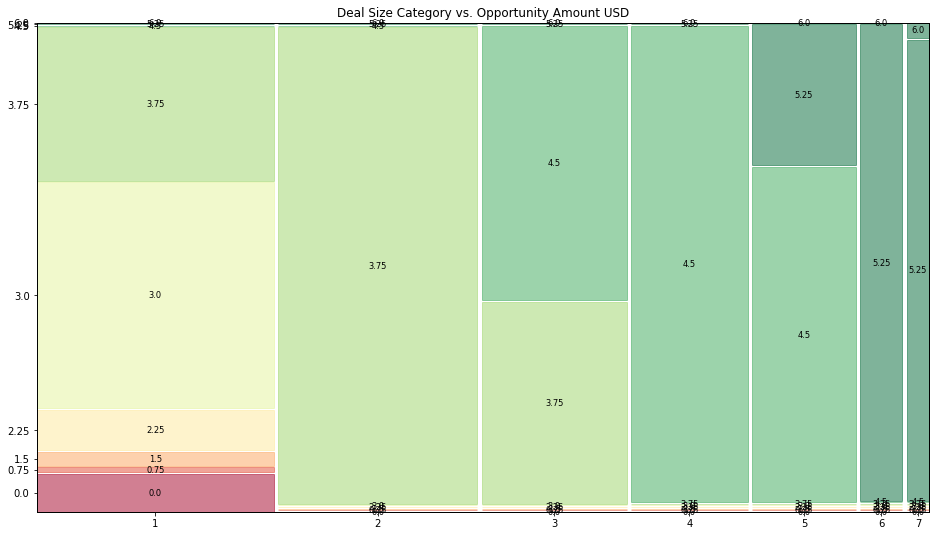

In [24]:
target = 'Opportunity Amount USD'
mdat = dat[dat["Opportunity Result"] == "Won"]
print("Non-normalized version")
umosaic(mdat, mdat.columns[1], target, True)
plt.show()

print("Normalized versions")
mdat[target] = np.log10(mdat[target] + 1)
for c in mdat.columns:
    if c == target:
        continue
    print(c)
    umosaic(mdat, c, target, True)
    plt.show()